# Estimating difference between conversion rate in A/B groups

In [1]:
import pandas as pd
import scipy as sp
import daft

import matplotlib.pyplot as plt
import numpy as np

from abtools.bayesian import BinaryABModel
from abtools.frequentist import PermutationTest, ZTest, TTest

%matplotlib inline
#plt.xkcd()

## Generate artificial data

Suppose our control group consists of 25k samples and has 10% percent conversion rate. Test (experiment) groups has 2.5% relative larger conversion rate.

In [2]:
p = .1
size = 25000
delta_true = .03

a = sp.stats.bernoulli.rvs(p=p, size=size, random_state=8228)
b = sp.stats.bernoulli.rvs(p=p*(1+delta_true), size=size, random_state=8228)

print('A - Mean: %.4f, std: %.2f' % (a.mean(), a.std()))
print('B - Mean: %.4f, std: %.2f' % (b.mean(), b.std()))
print('B better A on %.4f = %d%%' % (b.mean()- a.mean(), (b.mean()/a.mean()-1)*100))

A - Mean: 0.1010, std: 0.30
B - Mean: 0.1040, std: 0.31
B better A on 0.0030 = 2%


In [5]:
p = PermutationTest(a, b)

100%|██████████| 10000/10000 [00:08<00:00, 1193.84it/s]


In [6]:
p.summary()

Observed difference of means (E(B) - E(A)) = 0.0030
Test statistic is 0.0030 and critical value is 0.0062
Two-sided p-value = 0.25
Null hypotesis is not rejected with 0.05 significance level
E(A) = E(B)


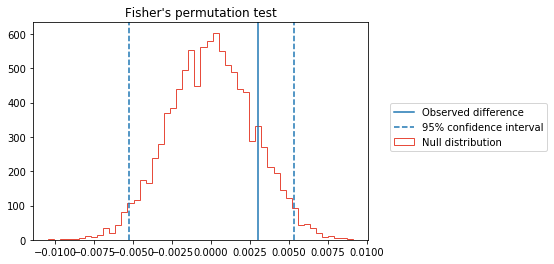

In [4]:
_.plot()

In [14]:
model = BinaryABModel(a, b)
model.fit()

/home/ivba/.local/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/home/ivba/.local/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 17853.425516
         Iterations: 14
         Function evaluations: 29
         Gradient evaluations: 21


100%|██████████| 10000/10000 [00:05<00:00, 1777.16it/s]


In [15]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$p_A$,0.100995,0.001942,0.000056,0.097132,0.104641
$p_B$,0.130184,0.002080,0.000052,0.126267,0.134470
$A_{\sigma^2}$,0.090791,0.001550,0.000045,0.087697,0.093691
$B_{\sigma^2}$,0.113232,0.001538,0.000038,0.110324,0.116387
$\Delta_p$,0.029190,0.002836,0.000072,0.023816,0.034841
$\Delta_{\sigma}$,0.035187,0.003429,0.000089,0.028196,0.041542
Effect size,0.091394,0.008877,0.000228,0.073639,0.108279


/home/ivba/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1daefb97b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1da98b7128>], dtype=object)

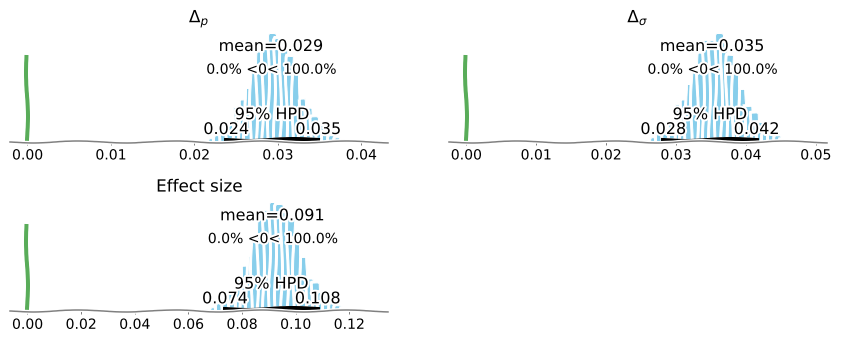

In [16]:
model.plot_deltas()

/home/ivba/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dafe6fc88>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1da879be10>], dtype=object)

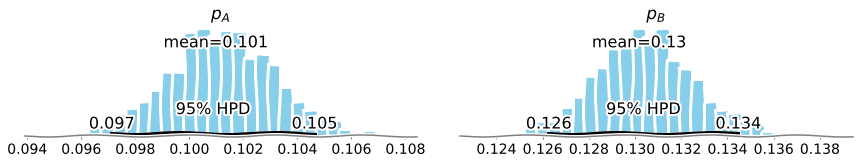

In [17]:
model.plot_params()

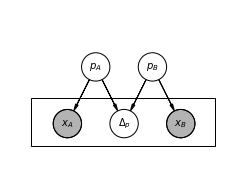

In [7]:
pgm = daft.PGM([4, 3], origin=[0, 0])
pgm.add_node(daft.Node("pA", r"$p_A$", 1.5, 2))
pgm.add_node(daft.Node("pB", r"$p_B$", 2.5, 2))
pgm.add_node(daft.Node("A_conv", r"$x_A$", 1, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("B_conv", r"$x_B$", 3, 1, aspect=1, observed=True))
pgm.add_node(daft.Node("d_conv", r"$\Delta_{p}$", 2, 1, aspect=1))

pgm.add_edge('pA','A_conv')
pgm.add_edge('pB','B_conv')
pgm.add_edge('pA','d_conv')
pgm.add_edge('pB','d_conv')

pgm.add_plate(daft.Plate([0.35, 0.7, 3.25, 0.75], shift=-0.1))
pgm.render()

pgm.figure.savefig("conversion_model.png", dpi=350)
pgm.figure.savefig("conversion_model.pdf", dpi=350, )